In [1]:
import sys
print(sys.executable)

/usr/local/bin/python3


In [2]:
!pip install pyportfolioopt

zsh:1: command not found: pip


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from pypfopt import EfficientFrontier, risk_models, expected_returns


In [4]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days = 365*5)

end_date, start_date

(datetime.datetime(2025, 7, 11, 23, 0, 57, 164069),
 datetime.datetime(2020, 7, 12, 23, 0, 57, 164069))

Lisk of Australian stocks from different industries.

In [5]:

stocks = ['CBA.AX', 'BHP.AX', 'CSL.AX', 'WES.AX', 'MQG.AX']
benchmark = ['^AXJO']

data = yf.download(stocks, start = start_date, end = end_date)['Close']
benchmark_data = yf.download(benchmark, start = start_date, end = end_date)['Close']

data.head()


/var/folders/kl/gftjsptj1fbfv3_9mcpxhp4r0000gn/T/ipykernel_30402/31196772.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, start = start_date, end = end_date)['Close']
[*********************100%***********************]  5 of 5 completed
/var/folders/kl/gftjsptj1fbfv3_9mcpxhp4r0000gn/T/ipykernel_30402/31196772.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data = yf.download(benchmark, start = start_date, end = end_date)['Close']
[*********************100%***********************]  1 of 1 completed


Ticker,BHP.AX,CBA.AX,CSL.AX,MQG.AX,WES.AX
Date,,,,,
2020-07-13,22.808937,59.953793,266.576935,102.742310,39.729961
2020-07-14,22.876804,59.629593,264.180450,102.195572,39.669571
2020-07-15,23.444405,60.460896,272.165527,104.138557,40.428802
2020-07-16,23.296335,60.386074,266.510590,104.920792,40.204475
2020-07-17,23.395046,60.352821,268.461945,105.290894,40.144081


In [6]:
benchmark_data.head()

Ticker,^AXJO
Date,
2020-07-13,5977.500000
2020-07-14,5941.100098
2020-07-15,6052.899902
2020-07-16,6010.899902
2020-07-17,6033.600098


In [7]:
# CALCULATING EXPECTED RETURN AND COVARIANCE MATRIX

mu = expected_returns.mean_historical_return(data, returns_data=True, frequency=252)

sigma = risk_models.sample_cov(data, returns_data=True, frequency=252)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:55: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


In [8]:
# Benchmark Returns

benchmark_returns = benchmark_data.pct_change().dropna()



# CALCULATING RETURN, Assume capitals are equally allocated

returns = data.pct_change().dropna()

portfolio_weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Assuming equal weights

portfolio_returns = (returns * portfolio_weights).sum(axis=1)


In [9]:
print("Portfolio Returns:")
print(returns.head())
      
print("Benchmark Returns:")
print(benchmark_returns.head())

Portfolio Returns:
Ticker        BHP.AX    CBA.AX    CSL.AX    MQG.AX    WES.AX
Date                                                        
2020-07-14  0.002975 -0.005407 -0.008990 -0.005321 -0.001520
2020-07-15  0.024811  0.013941  0.030226  0.019012  0.019139
2020-07-16 -0.006316 -0.001238 -0.020778  0.007511 -0.005549
2020-07-17  0.004237 -0.000551  0.007322  0.003527 -0.001502
2020-07-20  0.012131 -0.008402 -0.002541 -0.006391 -0.007092
Benchmark Returns:
Ticker         ^AXJO
Date                
2020-07-14 -0.006089
2020-07-15  0.018818
2020-07-16 -0.006939
2020-07-17  0.003777
2020-07-20 -0.005304


In [10]:

# Risk and performance metrics

annualized_return = ((1 + portfolio_returns.mean()) ** 252 - 1) * 100
volatility = portfolio_returns.std() * np.sqrt(252) * 100
sharpe_ratio = annualized_return / volatility



In [11]:
# Optimization
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()  # Optimize for maximum Sharpe ratio
cleaned_weights = ef.clean_weights()



In [12]:
# Print results
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Volatility: {volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print("Optimal Weights:", cleaned_weights)

Annualized Return: 15.64%
Volatility: 14.77%
Sharpe Ratio: 1.06
Optimal Weights: OrderedDict({'BHP.AX': 0.07462, 'CBA.AX': 0.74582, 'CSL.AX': 0.0, 'MQG.AX': 0.02787, 'WES.AX': 0.1517})


In [13]:
print(returns.columns)

Index(['BHP.AX', 'CBA.AX', 'CSL.AX', 'MQG.AX', 'WES.AX'], dtype='object', name='Ticker')


In [14]:
# benchmark cumulative return

benchmark_cumulative_returns = (1+benchmark_returns).cumprod()

# Using the optimum weights

optimal_portfolio_weight = np.array([0.0438, 0.7603, 0.0, 0.0484, 0.14751])
optimal_portfolio_returns = (returns * optimal_portfolio_weight).sum(axis=1)
optimal_cumulative_returns = (1+optimal_portfolio_returns).cumprod()


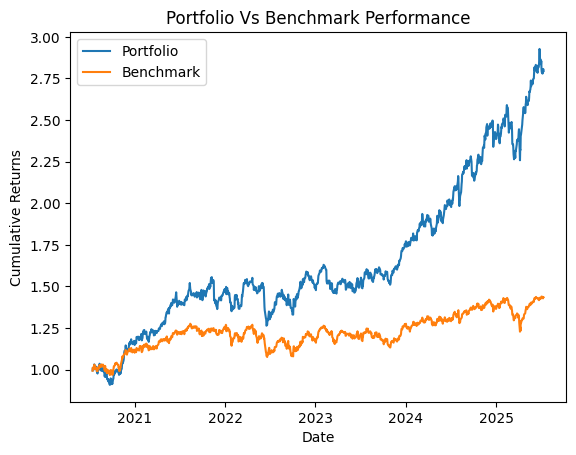

In [15]:
# Displaying the performance graph

plt.plot(optimal_cumulative_returns,  label ="Portfolio")
plt.plot(benchmark_cumulative_returns, label ="Benchmark")

plt.title("Portfolio Vs Benchmark Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()

plt.show()

In [16]:
print("Final Portfolio Value:", optimal_cumulative_returns.tail(1).values[0])
print("Final Benchmark Value:", benchmark_cumulative_returns.tail(1).values[0])


Final Portfolio Value: 2.794479485965914
Final Benchmark Value: [1.43539935]
